# VDOT tables analysis

This is a follow-up to the _VDOT basics_ notebook;
If you haven't, you should probably take a look at that one first.

The goal of this notebook is to quickly gauge how accurate the previous
approach is to estimating race times and defining training paces,
as well as try to _demistify Daniels' formula_. 🌈

## Table loading

Before any type of analysis can be performed, some ground-truth data is required.
I'll break it up in a couple of steps:

1. I'm definitely not going to be squinting for two hours while manually
   transcribing the VDOT tables, so I took a couple of screenshots,
   used a free online OCR service, and manually corrected any funky characters.
2. Do some lightweight data cleaning and wrangling.
3. Off-the-shelf visualizations as a quick sanity check.

In [1]:
raw_races = """\
VDOT   1,500  Mile  3,000  2 mile 5,000   10K   15K    Half marathon  Marathon  VDOT
30     8:30   9:11  17:56  19:19  30:40  63:46  98:14  2:21:04        4:49:17   30
31     8:15   8:55  17:27  18:48  29:51  62:03  95:36  2:17:21        4:41:57   31
32     8:02   8:41  16:59  18:18  29:05  60:26  93:07  2:13:49        4:34:59   32
33     7:49   8:27  16:33  17:50  28:21  58:54  90:45  2:10:27        4:28:22   33
34     7:37   8:14  16:09  17:24  27:39  57:26  88:30  2:07:16        4:22:03   34
35     7:25   8:01  15:45  16:58  27:00  56:03  86:22  2:04:13        4:16:03   35
36     7:14   7:49  15:23  16:34  26:22  54:44  84:20  2:01:19        4:10:19   36
37     7:04   7:38  15:01  16:11  25:46  53:29  82:24  1:58:34        4:04:50   37
38     6:54   7:27  14:41  15:49  25:12  52:17  80:33  1:55:55        3:59:35   38
39     6:44   7:17  14:21  15:29  24:39  51:09  78:47  1:53:24        3:54:34   39
40     6:35   7:07  14:03  15:08  24:08  50:03  77:06  1:50:59        3:49:45   40
41     6:27   6:58  13:45  14:49  23:38  49:01  75:29  1:48:40        3:45:09   41
42     6:19   6:49  13:28  14:31  23:09  48:01  73:56  1:46:27        3:40:43   42
43     6:11   6:41  13:11  14:13  22:41  47:04  72:27  1:44:20        3:36:28   43
44     6:03   6:32  12:55  13:56  22:15  46:09  71:02  1:42:17        3:32:23   44
45     5:56   6:25  12:40  13:40  21:50  45:16  69:40  1:40:20        3:28:26   45
46     549    6:17  12:26  13:25  21:25  44:25  68:22  1:38:27        3:24:39   46
47     5:42   6:10  12:12  13:10  21:02  43:36  67:06  1:36:38        3:21:00   47
48     5:36   6:03  11:58  12:55  20:39  42:50  65:53  1:34:53        3:17:29   48
49     5:30   5:56  11:45  12:41  20:18  42:04  64:44  1:33:12        3:14:06   49
50     5:24   5:50  11:33  12:28  19:57  41:21  63:36  1:31:35        3:10:49   50
51     5:18   5:44  11:21  12:15  19:36  40:39  62:31  1:30:02        3:07:39   51
52     5:13   5:38  11:09  12:02  19:17  39:59  61:29  1:28:31        3:04:36   52
53     5:07   5:32  10:58  11:50  18:58  39:20  60:28  1:27:04        3:01:39   53
54     5:02   5:27  10:47  11:39  18:40  38:42  59:30  1:25:40        2:58:47   54
55     4:57   5:21  10:37  11:28  18:22  38:06  58:33  1:24:18        2:56:01   55
56     4:53   5:16  10:27  11:17  18:05  37:31  57:39  1:23:00        2:53:20   56
57     4:48   5:11  10:17  11:06  17:49  36:57  56:46  1:21:43        2:50:45   57
58     4:44   5:06  10:08  10:56  17:33  36:24  55:55  1:20:30        2:48:14   58
59     4:39   5:02   9:58  10:46  17:17  35:52  55:06  1:19:18        2:45:47   59
60     4:35   4:57   9:50  10:37  17:03  35:22  54:18  1:18:09        2:43:25   60
61     4:31   4:53   9:41  10:27  16:48  34:52  53:32  1:17:02        2:41:08   61
62     4:27   4:49   9:33  10:18  16:34  34:23  52:47  1:15:57        2:38:54   62
63     4:24   4:45   9:25  10:10  16:20  33:55  52:03  1:14:54        2:36:44   63
64     4:20   4:41   9:17  10:01  16:07  33:28  51:21  1:13:53        2:34:38   64
65     4:16   4:37   9:09   9:53  15:54  33:01  50:40  1:12:53        2:32:35   65
66     4:13   4:33   9:02   9:45  15:42  32:35  50:00  1:11:56        2:30:36   66
67     4:10   4:30   8:55   9:37  15:29  32:11  49:22  1:11:00        2:28:40   67
68     4:06   4:26   8:48   9:30  15:18  31:46  48:44  1:10:05        2:26:47   68
69     4:03   4:23   8:41   9:23  15:06  31:23  48:08  1:09:12        2:24:57   69
70     4:00   4:19   8:34   9:16  14:55  31:00  47:32  1:08:21        2:23:10   70
71     3:57   4:16   8:28   9:09  14:44  30:38  46:58  1:07:31        2:21:26   71
72     3:54   4:13   8:22   9:02  14:33  30:16  46:24  1:06:42        2:19:44   72
73     3:52   4:10   8:16   8:55  14:23  29:55  45:51  1:05:54        2:18:05   73
74     3:49   4:07   8:10   8:49  14:13  29:34  45:19  1:05:08        2:16:29   74
75     3:46   4:04   8:04   8:43  14:03  29:14  44:48  1:04:23        2:14:55   75
76     3:44   4:02   7:58   8:37  13:54  28:55  44:18  1:03:39        2:13:23   76
77     3:41   3:58   7:53   8:31  13:44  28:36  43:49  1:02:56        2:11:54   77
78     3:38   3:56   7:48   8:25  13:35  28:17  43:20  1:02:15        2:10:27   78
79     3:36   3:53   7:43   8:20  13:26  27:59  42:52  1:01:34        2:09:02   79
80     3:34   3:51   7:37   8:14  13:17  27:41  42:25  1:00:54        2:07:38   80
81     3:31   3:48   7:32   8:08  13:09  27:24  41:58  1:00:15        2:06:17   81
82     3:29   3:46   7:27   8:03  13:01  27:07  41:32  0:59:38        2:04:57   82
83     3:27   3:44   7:23   7:58  12:53  26:51  41:06  0:59:01        2:03:40   83
84     3:25   3:41   7:18   7:53  12:45  26:34  40:42  0:58:25        2:02:24   84
85     3:23   3:39   7:14   7:48  12:37  26:19  40:17  0:57:50        2:01:10   85
"""

raw_paces1 = """\
VDOT   Easy (upper)   Easy (lower)  Marathon   Threshold
30        7:27           8:14        7:03       6:24
31        7:16           8:02        6:52       6:14
32        7:05           7:52        6:40       6:05
33        6:55           7:41        6:30       5:56
34        6:45           7:31        6:20       5:48
35        6:36           7:21        6:10       5:40
36        6:27           7:11        6:01       5:33
37        6:19           7:02        5:53       5:26
38        6:11           6:54        5:45       5:19
39        6:03           6:46        5:37       5:12
40        5:56           6:38        5:29       5:06
41        5:49           6:31        5:22       5:00
42        5:42           6:23        5:16       4:54
43        5:35           6:16        5:09       4:49
44        5:29           6:10        5:03       4:43
45        5:23           6:03        4:57       4:38
46        5:17           5:57        4:51       4:33
47        5:12           5:51        4:46       4:29
48        5:07           5:45        4:41       4:24
49        5:01           5:40        4:36       4:20
50        4:56           5:34        4:31       4:15
51        4:52           5:29        4:27       4:11
52        4:47           5:24        4:22       4:07
53        4:43           5:19        4:18       4:04
54        4:38           5:14        4:14       4:00
55        4:34           5:10        4:10       3:56
56        4:30           5:05        4:06       3:53
57        4:26           5:01        4:03       3:50
58        4:22           4:57        3:59       3:46
59        4:19           4:53        3:56       3:43
60        4:15           4:49        3:52       3:40
61        4:11           4:45        3:49       3:37
62        4:08           4:41        3:46       3:34
63        4:05           4:38        3:43       3:32
64        4:02           4:34        3:40       3:29
65        3:59           4:31        3:37       3:26
66        3:56           4:28        3:34       3:24
67        3:53           4:24        3:31       3:21
68        3:50           4:21        3:29       3:19
69        3:47           4:18        3:26       3:16
70        3:44           4:15        3:24       3:14
71        3:42           4:12        3:21       3:12
72        3:40           4:00        3:19       3:10
73        3:37           4:07        3:16       3:08
74        3:34           4:04        3:14       3:06
75        3:32           4:01        3:12       3:04
76        3:30           3:58        3:10       3:02
77        3:28           3:56        3:08       3:00
78        3:25           3:53        3:06       2:58
79        3:23           3:51        3:03       2:56
80        3:21           3:49        3:01       2:54
81        3:19           3:46        3:00       2:53
82        3:17           3:44        2:58       2:51
83        3:15           3:42        2:56       2:49
84        3:13           3:40        2:54       2:48
85        3:11           3:38        2:52       2:46
"""

raw_paces2 = """\
400m    Km   1,200m   Mile  200m   300m   400m   600m   800m  VDOT
2:22                         67    1:41                        30
2:18                         65     98                         31
2:14                         63     95                         32
2:11                         61     92                         33
2:08                         60     90     2:00                34
2:05                         58     87     1:57                35
2:02                         57     85     1:54                36
1:59   5:00                  55     83     1:51                37
1:56   4:54                  54     81     1:48                38
1:54   4:48                  53     80     1:46                39
1:52   4:42                  52     78     1:44                40
1:50   4:36                  51     77     1:42                41
1:48   4:31                  50     75     1:40                42
1:46   4:26                  49     74     98                  43
1:44   4:21                  48     72     96                  44
1:42   4:16                  47     71     94                  45
1:40   4:12   5:00           46     69     92                  46
 98    4:07   4:54           45     68     90                  47
 96    4:03   4:49           44     67     89                  48
 95    3:59   4:45           44     66     88                  49
 93    3:55   4:40           43     65     87                  50
 92    3:51   4:36           43     64     86                  51
 91    3:48   4:32           42     64     85                  52
 90    3:44   4:29           42     63     84                  53
 88    3:41   4:25           41     62     82                  54
 87    3:37   4:21           40     61     81                  55
 86    3:34   4:18           40     60     80     2:00         56
 85    3:31   4:14           39     59     79     1:57         57
 83    3:28   4:10           38     58     77     1:55         58
 82    3:25   4:07           38     57     76     1:54         59
 81    3:23   4:03           37     56     75     1:52         60
 80    3:20   4:00           37     55     74     1:51         61
 79    3:17   3:57           36     54     73     1:49         62
 78    3:15   3:54           36     53     72     1:48         63
 77    3:12   3:51           35     52     71     1:46         64
 76    3:10   3:48           35     52     70     1:45         65
 75    3:08   3:45    5:00   34     51     69     1:43         66
 74    3:05   3:42    4:57   34     51     68     1:42         67
 73    3:03   3:39    4:53   33     50     67     1:40         68
 72    3:01   3:36    4:50   33     49     66     99           69
 71    2:59   3:34    4:46   32     48     65     97           70
 70    2:57   3:31    4:43   32     48     64     96           71
 69    2:55   3:29    4:40   31     47     63     94           72
 69    2:53   3:27    4:37   31     47     63     93           73
 68    2:51   3:25    4:34   31     46     62     92           74
 67    2:49   3:22    4:31   30     46     61     91           75
 66    2:48   3:20    4:28   30     45     60     90           76
 65    2:46   3:18    4:25   29     45     59     89     2:00  77
 65    2:44   3:16    4:23   29     44     59     88     1:59  78
 64    2:42   3:14    4:20   29     44     58     87     1:58  79
 64    2:41   3:12    4:17   29     43     58     87     1:56  80
 63    2:39   3:10    4:15   28     43     57     86     1:55  81
 62    2:38   3:08    4:12   28     42     56     85     1:54  82
 62    2:36   3:07    4:10   28     42     56     84     1:53  83
 61    2:35   3:05    4:08   27     41     55     83     1:52  84
 61    2:33   3:03    4:05   27     41     55     82     1:51  85
"""

In [2]:
from io import StringIO

import pandas as pd

races = pd.read_fwf(StringIO(raw_races))

races = races[["VDOT", "5,000", "10K", "Half marathon", "Marathon"]]
races = races.rename(columns={"5,000": "5K"})
races = races.set_index("VDOT")

races.head()

,5K,10K,Half marathon,Marathon
VDOT,,,,
30,30:40,63:46,2:21:04,4:49:17
31,29:51,62:03,2:17:21,4:41:57
32,29:05,60:26,2:13:49,4:34:59
33,28:21,58:54,2:10:27,4:28:22
34,27:39,57:26,2:07:16,4:22:03


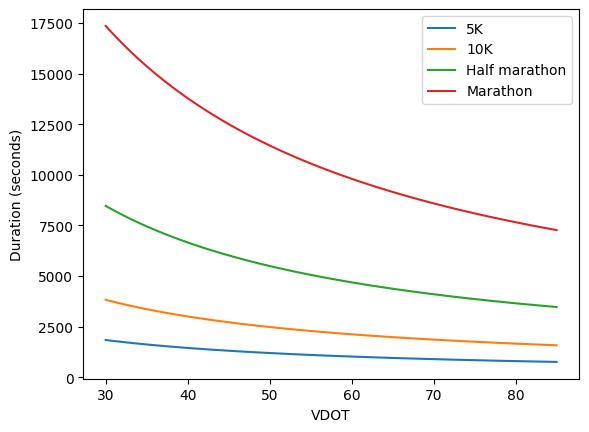

In [3]:
import matplotlib.pyplot as plt


def parse_time(s):
    """Transform from a hh:mm:ss format to number of seconds."""
    if isinstance(s, (int, float)):
        return s

    match s.split(":"):
        case [hh, mm, ss]:
            return int(hh) * 3600 + int(mm) * 60 + int(ss)
        case [mm, ss]:
            return int(mm) * 60 + int(ss)
        case [ss]:
            return int(ss)
        case _:
            raise ValueError


races = races.applymap(parse_time)

ax = races.plot(ylabel="Duration (seconds)")
plt.show()

---

That's the race times done! Moving on to the training pace tables.

In [4]:
paces1 = pd.read_fwf(StringIO(raw_paces1))

paces1 = paces1[["VDOT", "Easy (lower)", "Easy (upper)", "Marathon", "Threshold"]]
paces1 = paces1.set_index("VDOT")
paces1 = paces1.applymap(parse_time)

paces1.head()

,Easy (lower),Easy (upper),Marathon,Threshold
VDOT,,,,
30,494,447,423,384
31,482,436,412,374
32,472,425,400,365
33,461,415,390,356
34,451,405,380,348


Calculating min/km paces for Interval/Repetitions is slightly harder
because of the format provided.

In short, **we'll extrapolate times for the Km based on the closer distance available**
(e.g. 400m when neither 600m or 800m times are present).

When doing this we can disregard times for distances longer than 1Km in the case
of Interval paces, and the 200m column for the Repetition paces
(every VDOT value has a time for the 300m).

In [5]:
paces2 = pd.read_fwf(StringIO(raw_paces2))

paces2 = paces2.drop(columns=["1,200m", "Mile", "200m"])
paces2 = paces2.set_index("VDOT")
paces2 = paces2.applymap(parse_time)

paces2.head()

,400m,Km,300m,400m.1,600m,800m
VDOT,,,,,,
30,142,NaN,101,NaN,NaN,NaN
31,138,NaN,98,NaN,NaN,NaN
32,134,NaN,95,NaN,NaN,NaN
33,131,NaN,92,NaN,NaN,NaN
34,128,NaN,90,120.0,NaN,NaN


In [6]:
# transformation for interval paces
paces2["400m"] *= 2.5
paces2["Interval"] = paces2[["Km", "400m"]].bfill(axis="columns").iloc[:, 0]

# transformations for repetitions paces
paces2["300m"] *= 3.33
paces2["400m.1"] *= 2.5
paces2["600m"] *= 1.67
paces2["800m"] *= 1.25
paces2["Repetitions"] = (
    paces2[["800m", "600m", "400m.1", "300m"]].bfill(axis="columns").iloc[:, 0]
)

paces2 = paces2[["Interval", "Repetitions"]].round().astype(int)
paces2.head()

,Interval,Repetitions
VDOT,,
30,355,336
31,345,326
32,335,316
33,328,306
34,320,300


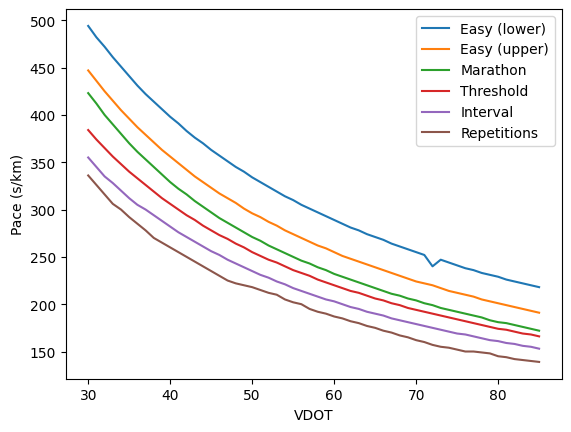

In [7]:
paces = pd.concat([paces1, paces2], axis=1)

ax = paces.plot(ylabel="Pace (s/km)")
plt.show()

## Race time estimation analysis

Let's estimate race times using the **root-finding bisection method**
introduced in the first notebook:

In [8]:
from datetime import timedelta

import numpy as np
from scipy import optimize

distances = {
    "5K": 5000,
    "10K": 10000,
    "Half marathon": 21097.5,
    "Marathon": 42195,
}


def f(x, vdot, d):
    return (-4.6 + 0.182258 * d * x ** (-1) + 0.000104 * d**2 * x ** (-2)) / (
        0.8 + 0.1894393 * np.exp(-0.012778 * x) + 0.2989558 * np.exp(-0.1932605 * x)
    ) - vdot


records = []
for vdot in range(30, 86):
    row = {}
    for name, d in distances.items():
        root = optimize.bisect(f, 1, 600, args=(vdot, d))
        row[name] = round(timedelta(minutes=root).total_seconds())
    records.append(row)

mine = pd.DataFrame.from_records(records, index=pd.Index(range(30, 86), name="VDOT"))
mine.head()

,5K,10K,Half marathon,Marathon
VDOT,,,,
30,1841,3829,8477,17389
31,1791,3725,8250,16941
32,1745,3627,8035,16517
33,1700,3534,7831,16114
34,1658,3445,7637,15731


Now to come up with a quick visual guide on how "accurate" the method is:

In [9]:
import seaborn as sns

deviation = mine - races

cm = sns.color_palette("vlag", as_cmap=True)
deviation.T.style.background_gradient(cmap=cm, axis=None, vmin=-30, vmax=30)

VDOT,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
5K,1,0,0,-1,-1,-1,-1,-1,-2,-1,-2,-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,0,0
10K,3,2,1,0,-1,-1,-2,-2,-2,-3,-2,-3,-3,-3,-3,-3,-2,-2,-2,-1,-1,-1,-1,-1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0
Half marathon,13,9,6,4,1,0,-1,-3,-4,-5,-5,-5,-5,-6,-5,-6,-6,-5,-5,-4,-4,-4,-3,-3,-3,-2,-2,-1,-2,-1,0,0,0,0,1,1,1,1,2,2,2,2,2,3,2,3,3,3,2,2,3,3,2,2,2,1
Marathon,32,24,18,12,8,3,0,-3,-5,-7,-8,-9,-10,-11,-11,-10,-10,-10,-10,-10,-9,-9,-8,-8,-7,-6,-5,-5,-5,-3,-3,-3,-2,-1,-1,0,1,1,2,2,3,3,4,4,4,4,5,5,4,4,5,5,6,5,5,5


Looks pretty accurate as it does not deviate more than 32 seconds for the whole table
(and that is for the longest, slowest race -
which amounts to a mere 0.18% deviation in total seconds).

Good enough for me!

## Training pace definition analysis

For training paces, it's a sightly more complicated matter...
Daniels does never mention specifically how he calculates any of his training paces.
He mentions typical intensity ranges based on $\%\mathrm{\dot{V}O_2max}$,
but only mentions pace ranges for easy runs;
Every other run type has a single value attributed to it.

Previously I stuck to calculating pace ranges but for the sake of simplicity and conformity,
it might be useful to try and land on a single value.

---

A quick "state-of-the-art" search yielded a couple of results:

1. User `math major` in a
   [letsrun.com discussion](https://www.letsrun.com/forum/flat_read.php?thread=3704747)
   (2010) suggests:

   - Easy: 67% (working nicely for VDOTs of 36-85)
   - Marathon: ~82% (not a fixed $\%\mathrm{\dot{V}O_2max}$ accross VDOTs;
     another user suggests using the predicted performance of a marathon race)
   - Threshold: 88%
   - Interval: 97.5%
   - Repetitions: ~120% (like marathon pace, not smooth accross VDOTs)

2. https://vdot.fit source code points to a couple different values:

   - Easy lower / upper: 62% / 70%
   - Marathon: 82%
   - Threshold: 88%
   - Interval: 97.5%
   - Repetitions: 107.5%

This suggests that easy, threshold, and intervals are nicely defined as
$\%\mathrm{\dot{V}O_2max}$, but others are obtained some other way.

Let's start with confirming this by doing some **quick and dirty curve fitting**
(using the relationship between oxygen consumption and velocity)
to the paces table:

In [10]:
from scipy.optimize import curve_fit


def func(x, p):
    return (-0.182258 + np.sqrt(0.033218 - 0.000416 * (-4.6 - (x * p)))) / 0.000208


paces_t = 1000 / (paces / 60)  # meters/min instead of seconds/km

d = {}
xdata = paces_t.index.values
for i, c in enumerate(paces_t):
    ydata = paces_t.iloc[:, i].values
    popt, _ = curve_fit(func, xdata, ydata)

    pct = round(popt[0], 4)
    print(f"{c:12} : {pct}")

    d[c] = func(xdata, pct)

Easy (lower) : 0.6304
Easy (upper) : 0.7346
Marathon     : 0.8251
Threshold    : 0.8799
Interval     : 0.9743
Repetitions  : 1.089


Using the percentages obtained above, let's create some pace estimates
using the $\%\mathrm{\dot{V}O_2max}$ approach:

In [11]:
mine = (1000 / pd.DataFrame(d, index=paces.index)) * 60
mine = mine.round().astype(int)
mine.head()

,Easy (lower),Easy (upper),Marathon,Threshold,Interval,Repetitions
VDOT,,,,,,
30,497,442,404,384,354,324
31,485,431,394,374,345,316
32,473,421,384,365,337,308
33,462,411,375,356,329,301
34,452,401,366,348,321,293


As before, let's look at some visuals to quickly interpret
how far we are from the tabled values.

It's important to note here that these are paces and not durations,
so **any second deviation should be much more significant than on the
case of race times**.

In [12]:
deviation = mine - paces
deviation.T.style.background_gradient(cmap=cm, axis=None, vmin=-20, vmax=20)

VDOT,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
Easy (lower),3,3,1,1,1,1,1,1,1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,0,-1,0,0,-1,-1,-1,0,0,-1,0,-1,-1,0,0,0,0,0,9,-1,-1,0,0,0,0,0,-1,0,0,0,0,0
Easy (upper),-5,-5,-4,-4,-4,-4,-3,-4,-3,-3,-3,-3,-2,-2,-2,-2,-1,-2,-2,-1,-1,-1,-1,-1,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,1,1,1,1,1,1,1
Marathon,-19,-18,-16,-15,-14,-12,-11,-11,-10,-9,-7,-7,-7,-5,-5,-4,-3,-3,-3,-3,-2,-2,-2,-2,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,2,2,2,3,3
Threshold,0,0,0,0,0,0,-1,-1,-1,0,0,0,0,-1,0,0,0,-1,0,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Interval,-1,0,2,1,1,1,1,0,-1,-1,-1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
Repetitions,-12,-10,-8,-5,-7,-5,-5,-4,-2,-2,-3,-3,-3,-2,-2,-1,0,1,0,-2,-3,-4,-4,-5,-3,-3,-4,-2,-2,-2,-2,-2,-2,-2,-1,-1,0,-1,0,1,2,2,3,3,2,3,3,2,1,0,2,2,2,2,1,1


Here I've highlighted the +-5 second range as an arbitrary measure of accuracy;
I find that, especially for training paces,
a _discrepancy_ of 5 seconds is perfectly tolerable.

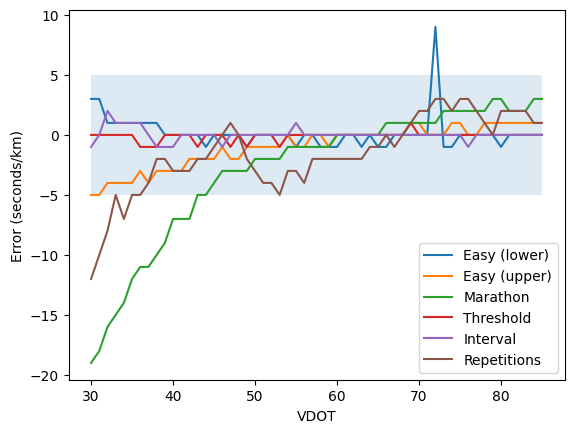

In [13]:
ax = deviation.plot(ylabel="Error (seconds/km)")
ax.fill_between(deviation.index.values, -5, 5, alpha=0.15)

plt.show()

This confirms the initially defined idea that easy, threshold,
and interval paces can be accurately estimated by the
$\%\mathrm{\dot{V}O_2max}$ approach.

### Refining marathon pace estimation

Let's now take a look using the predicted marathon race time to
define the marathon pace (duh).

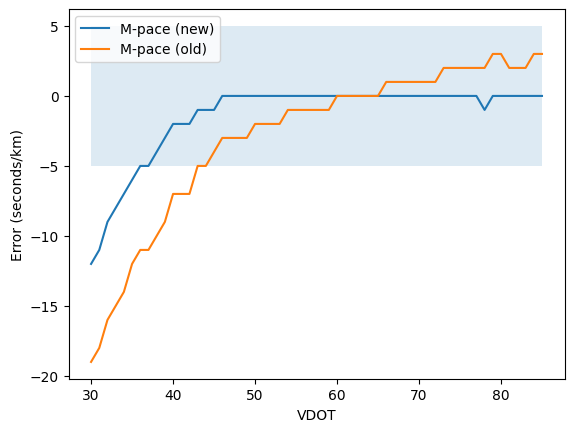

In [14]:
m_pace = (races["Marathon"] / 42.195).round().astype(int)
m_deviation = m_pace - paces["Marathon"]

m_errors = pd.concat([m_deviation, deviation["Marathon"]], axis=1)
m_errors.columns = ["M-pace (new)", "M-pace (old)"]

ax = m_errors.plot(ylabel="Error (seconds/km)")
ax.fill_between(m_errors.index.values, -5, 5, alpha=0.15)

plt.show()

This is a rather sizeable improvement,
but still produces disappointing results for VDOTs below 40.
I'm starting to think he does some manual data fudging for the lower ends of the VDOT scale.

### Refining repetitions pace estimation

When it comes to the error peratining to repetitions pace,
one hint could be to what the book refers to as _Daniels' 6-Second Rule_;
It states that typically "I pace [is] 6 seconds per 400 slower than R pace".

Since I'm a good boy that deals with metric units and likes round numbers,
I'll adapt that to "I pace is 15 seconds per 1Km slower than R pace".
Let's see if that helps:

In [15]:
r_pace = mine["Interval"] - 15
r_deviation = r_pace - paces["Repetitions"]

r_errors = pd.concat([r_deviation, deviation["Repetitions"]], axis=1)
r_errors.columns = ["R-pace (new)", "R-pace (old)"]

r_errors.T.style.background_gradient(cmap=cm, axis=None, vmin=-15, vmax=15)

VDOT,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
R-pace (new),3,4,6,8,6,6,6,7,8,7,6,6,6,6,6,6,6,7,6,4,2,1,1,-1,1,1,-1,1,1,0,1,0,0,0,0,0,1,0,1,1,2,2,3,3,2,2,2,1,0,-1,1,0,1,0,0,-1
R-pace (old),-12,-10,-8,-5,-7,-5,-5,-4,-2,-2,-3,-3,-3,-2,-2,-1,0,1,0,-2,-3,-4,-4,-5,-3,-3,-4,-2,-2,-2,-2,-2,-2,-2,-1,-1,0,-1,0,1,2,2,3,3,2,3,3,2,1,0,2,2,2,2,1,1


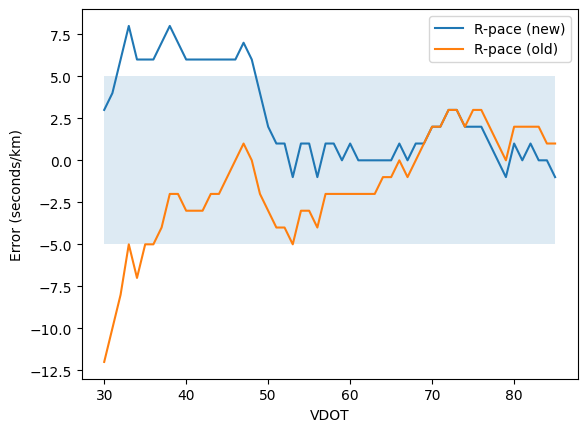

In [16]:
ax = r_errors.plot(ylabel="Error (seconds/km)")
ax.fill_between(r_errors.index.values, -5, 5, alpha=0.15)

plt.show()

That doesn't look as improvement at all...
Daniels mentions however that this rule "applies more accurately to better runners"
and even suggests making it into a 7- or 8-second rule for
runners with a VDOT below 50.

Let's try that:

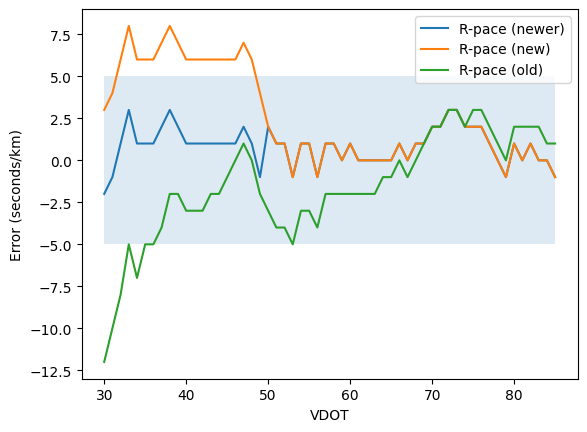

In [17]:
r_pace2 = mine["Interval"] - pd.Series([20] * 20 + [15] * 36, index=paces.index)
r_deviation2 = pd.Series(r_pace2 - paces["Repetitions"], name="R-pace (newer)")

r_errors2 = pd.concat([r_deviation2, r_errors], axis=1)

ax = r_errors2.plot(ylabel="Error (seconds/km)")
ax.fill_between(r_errors2.index.values, -5, 5, alpha=0.15)

plt.show()

Great success! This branching approach yields much better results, I'd say.

## Putting it all together

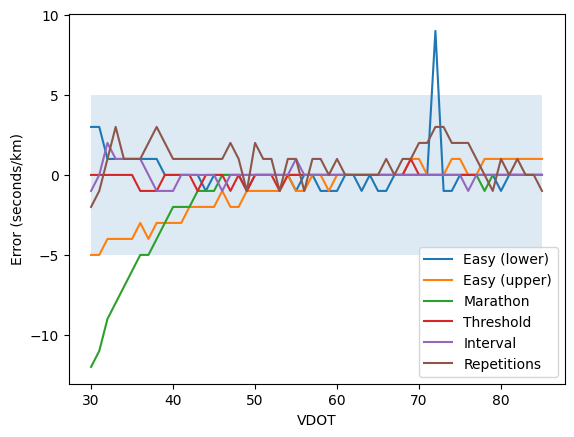

In [18]:
mine["Marathon"] = m_pace
mine["Repetitions"] = r_pace2

deviation = mine - paces

ax = deviation.plot(ylabel="Error (seconds/km)")
ax.fill_between(deviation.index.values, -5, 5, alpha=0.15)

plt.show()